In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    #!git clone https://github.com/mjwock/DeepFLaSH_Pytorch.git /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI/
    %cd /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI2
    #!git pull
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

!pip install elasticdeform

from fastai.vision import *
from torch import nn
import torch.nn.functional as F
import torchvision
from sklearn.model_selection import StratifiedKFold

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

from deepflash import preproc, unetadaption, losses, mask_converter

from skimage import io
from tqdm import tqdm

import elasticdeform
import random
import os
from pathlib import Path, PurePath
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
import inspect
inspect.getfile(vision)

'/usr/local/lib/python3.6/dist-packages/fastai/vision/__init__.py'

## Settings

General Params

In [0]:
DIR = '/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2/data'


MASK_TYPE = 'cFOS'   # 'cFOS','Parv','NeuN'
CODER = ['gt']  # 'gt','cora','corinna','dennis','manju','manual','rohini','unet_cv10','unet_cv36'
COLOR = 'red'   # 'red','green'

TILE_SHAPE = (540,540)    # desired input
PADDING = (184,184)       # 540-356
EL_SIZE = [635.9, 635.9]

CALC_WEIGHTS = False      # calculate weights for lossfunction, else load saved weights
SAVE_WEIGHTS = True       # if weights are not loaded, save these or not
WEIGHT_FILE = 'weightmaps.npy'  # which weights to load/save

SEED = 42

In [0]:
# ONLY CHANGE FOR DIFFERENT FOLDER STRUCTURE
IMG_PATH = f'{DIR}/images/{COLOR}'
MASK_PATH = f'{DIR}/temp_data/labels/'

Weight Params

In [0]:
LAMBDA = 50 #50
V_BAL = 0.1 #0.1
SIGMA_BAL = 10 #10 
SIGMA_SEP = 6 #6

Training Params

In [0]:
BATCH_NORM = False
BATCH_SIZE = 5
EPOCHS = 100
N_SPLITS = 10

Network Params

In [0]:
IN_CHANNELS = 1
OUT_CHANNELS = 2  #number of classes
DEPTH = 5

# Custom Net Overview

In [26]:
from torchsummary import summary
#GPU Hardware Acceleration needed (cuda)

net = unetadaption.UNet(in_channels=IN_CHANNELS,n_classes=OUT_CHANNELS,depth=DEPTH).cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)

summary(model, input_size=(IN_CHANNELS, TILE_SHAPE[0], TILE_SHAPE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 538, 538]             640
              ReLU-2         [-1, 64, 538, 538]               0
            Conv2d-3         [-1, 64, 536, 536]          36,928
              ReLU-4         [-1, 64, 536, 536]               0
     UNetConvBlock-5         [-1, 64, 536, 536]               0
            Conv2d-6        [-1, 128, 266, 266]          73,856
              ReLU-7        [-1, 128, 266, 266]               0
            Conv2d-8        [-1, 128, 264, 264]         147,584
              ReLU-9        [-1, 128, 264, 264]               0
    UNetConvBlock-10        [-1, 128, 264, 264]               0
           Conv2d-11        [-1, 256, 130, 130]         295,168
             ReLU-12        [-1, 256, 130, 130]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

## Load Data

Retrieve images from folder

In [0]:
filenames = os.listdir(IMG_PATH)

img_ids = [os.path.splitext(files)[0] for files in filenames] #get list with img_ids
img_ext = os.path.splitext(filenames[0])[1] #get image extension

In [0]:
images = [img_name for img_name in [f'{s}{img_ext}' for s in img_ids]]
img_df = pd.DataFrame([Path(image) for image in images])

Function to map from image path to mask and weight paths

In [0]:
### TODO: fix for multiple coder: CODER[i]
regDigits = "\d{4}"
get_labels = lambda x: Path(f'{DIR}/temp_data/labels/{re.findall(regDigits,Path(x).stem)[0]}.tif')
get_weights = lambda x: Path(f'{DIR}/temp_data/weights/{re.findall(regDigits,Path(x).stem)[0]}.tif')

Show example image + mask

/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_packbits'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'decode_lzw'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'unpack_ints'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))
/usr/local/lib/python3.6/dist-packages/imageio/plugins/_tifffile.py:7285: UserWarning: module 'imageio.plugins._tifffile' has no attribute 'reverse_bitorder'
  Functionality might be degraded or be slow.

  warnings.warn("%s%s" % (e, warn))


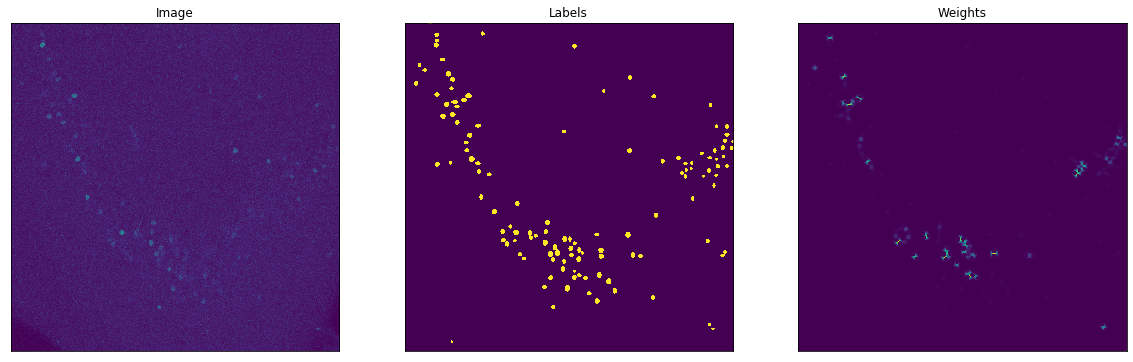

In [13]:
rndExample = random.randrange(0, len(images)-1)
rndImage = str(img_df.iat[rndExample,0])

imgEx = io.imread(f'{IMG_PATH}/{rndImage}')
imgEx = pil2tensor(imgEx,np.float32)[0]

maskEx = io.imread(get_labels(rndImage))
maskEx = pil2tensor(maskEx,np.float32)[0]

weightEx = io.imread(get_weights(rndImage))
weightEx = pil2tensor(weightEx,np.float32)[0]

f, axarr = plt.subplots(1,3,figsize=(20,10))
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
axarr[0].imshow(imgEx)
axarr[0].title.set_text('Image')
axarr[1].imshow(maskEx)
axarr[1].title.set_text('Labels')
axarr[2].imshow(weightEx)
axarr[2].title.set_text('Weights')

# Create Databunch object for further training

In [0]:
mask_size = tuple(np.subtract(TILE_SHAPE,PADDING))

class TfmCropY(TfmPixel):
    "Decorator for crop tfm funcs."
    order=100

def _do_crop_y(x,mask_size=mask_size):
  rows,cols = tis2hw(mask_size)
  row = int((x.size(1)-rows+1) * 0.5)
  col = int((x.size(2)-cols+1) * 0.5)
  x = x[:, row:row+rows, col:col+cols].contiguous()
  return x

do_crop_y = TfmCropY(_do_crop_y)

Custom ItemBase to store and process labels and pixelweights together

In [0]:
class WeightedLabels(ItemBase):
  def __init__(self, lbl:Image, wgt:Image):
    """New item class for weights and labels"""
    self.lbl,self.wgt = lbl,wgt
    self.obj,self.data = (lbl,wgt),[lbl.data, wgt.data]

  def apply_tfms(self, tfms, crop_to_target_size:Tuple=(356,356),**kwargs):   #TRY TO CHANGE INPUT FROM CALL 'crop_to_target_size'
    # if mask should be cropped, add operation 'do_crop_y' to transforms
    if crop_to_target_size:
      if not tfms:
        tfms = []
      tfms.append(do_crop_y(mask_size=crop_to_target_size))

    # transform labels and weights seperately
    self.lbl = self.lbl.apply_tfms(tfms, **kwargs)
    self.wgt = self.wgt.apply_tfms(tfms, **kwargs)
    self.data = [self.lbl.data, self.wgt.data]
    return self

  def __repr__(self):
    return f'{self.__class__.__name__}{(self.lbl, self.wgt)}'

**Data Structure**

Custom ItemLists for combining and processing the WeightedLabels ItemBase

In [0]:
class CustomSegmentationLabelList(ImageList):
  "'Item List' suitable for DeepFLaSH Masks"
  _processor= vision.data.SegmentationProcessor
  def __init__(self, 
               items:Iterator, 
               wghts=None,
               classes:Collection=None,
               loss_func=CrossEntropyFlat(axis=1),
               **kwargs):
    
    super().__init__(items,**kwargs)
    self.copy_new.append('classes')
    self.copy_new.append('wghts')
    self.classes,self.loss_func,self.wghts = classes,loss_func, wghts

  def open(self, fn): 
    res = io.imread(fn)
    res = pil2tensor(res,np.float32)
    return Image(res)

  def get(self, i):
    fn = super().get(i)
    wt = self.wghts[i]
    return WeightedLabels(fn,self.open(wt))
  
  def reconstruct(self, t:Tensor):
    return WeightedLabels(Image(t[0]),Image(t[1]))

  #def analyze_pred(self, pred, thresh:float=0.5): return pred.argmax(dim=0)[None]
     
class CustomSegmentationItemList(ImageList):
  "'ItemList' suitable for segmentation with pixelwise weighted loss"
  _label_cls,_square_show_res = CustomSegmentationLabelList,False

  def label_from_funcs(self, get_labels:Callable, get_weights:Callable,
                       label_cls:Callable=None, classes=None, **kwargs)->'LabelList':
    "Get weights and labels from two functions. Saves them in a CustomSegmentationLabelList"
    kwargs = {}
    wghts = [get_weights(o) for o in self.items]
    labels = [get_labels(o) for o in self.items]
    
    y = CustomSegmentationLabelList(labels,wghts,classes,path=self.path)
    res = self._label_list(x=self, y=y)
    return res



  def show_xys(self, xs, ys, figsize:Tuple[int,int]=None, padding=184, **kwargs):
    "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."

    if not figsize:
      figsize = (18,6*len(xs))

    #colormap for labels
    lmap = plt.get_cmap('Dark2')
    lmap.set_under('k', alpha=0)

    #colormap for weights
    wmap = plt.get_cmap('YlOrRd') #YlOrRd PuRd
    wmap.set_under('k', alpha=0)
    wmax = np.unique(ys[0].wgt.data)[-1]*0.9

    same_size = (ys[0].lbl.size == xs[0].size)

    #get width from x and set red boundingbox
    wdt, hgt = xs[0].size

    if not same_size:
      padding = int(0.5*(wdt - ys[0].lbl.size[1]))  #####numpy pad

                            #(x-offset,y-offset)      ,width      ,height
    bbox = patches.Rectangle((padding-1,padding-1),wdt-2*padding,hgt-2*padding,edgecolor='r',linewidth=1,facecolor='none')

    #rows: number of batch items
    rows = len(xs)
    fig, axs = plt.subplots(rows,3,figsize=figsize)
    #idx: batch item counter
    idx = 0
    for i, ax in enumerate(axs.flatten() if rows > 1 else axs):
      #display image and labels together
      if(i%3==0):
        # normalize the images for a better visualization
        imax = np.unique(xs[idx].data)[-1]

        y_label = np.asarray(ys[idx].lbl.data[0])
        y_label = np.pad(y_label, padding, 'constant', constant_values=(0))

        ax.imshow(np.asarray(xs[idx].data[0]),vmax=imax, cmap='binary', interpolation='none') #cmap= bone_r
        ax.imshow(y_label, cmap=lmap, vmin=0.2, alpha=0.8, interpolation='none')
        ax.add_patch(copy(bbox))
        ax.set_title('Image + Labels')

      #display image and weights together
      elif(i%3==1):

        y_weights = np.asarray(ys[idx].wgt.data[0])
        y_weights = np.pad(y_weights, padding, 'constant', constant_values=(0))

        ax.imshow(np.asarray(xs[idx].data[0]), vmax=imax, cmap='binary', interpolation='none')
        ax.imshow(y_weights, vmax=wmax, cmap=wmap, vmin=0.15, alpha=0.5,interpolation='none')

        ax.add_patch(copy(bbox))
        ax.set_title('Image + Weights')

      #display labels and weights together       
      else:
        ax.imshow(y_weights,vmax=wmax, cmap=wmap,vmin=0.15,interpolation='none')
        ax.imshow(y_label, cmap=lmap,vmin=0.1,alpha=1,interpolation='none')
        ax.add_patch(copy(bbox))
        ax.set_title('Labels + Weights')

        idx +=1
    plt.tight_layout()

Definition of the elastic deformation function

In [0]:
def _normalize_inputs(X):
    if isinstance(X, np.ndarray):
        Xs = [X]
    elif isinstance(X, list):
        Xs = X
    else:
        raise Exception('X should be a numpy.ndarray or a list of numpy.ndarrays.')

    # check X inputs
    assert len(Xs) > 0, 'You must provide at least one image.'
    assert all(isinstance(x, np.ndarray) for x in Xs), 'All elements of X should be numpy.ndarrays.'
    return Xs

def _normalize_axis_list(axis, Xs):
    if axis is None:
        axis = [tuple(range(x.ndim)) for x in Xs]
    elif isinstance(axis, int):
        axis = (axis,)
    if isinstance(axis, tuple):
        axis = [axis] * len(Xs)
    assert len(axis) == len(Xs), 'Number of axis tuples should match number of inputs.'
    input_shapes = []
    for x, ax in zip(Xs, axis):
        assert isinstance(ax, tuple), 'axis should be given as a tuple'
        assert all(isinstance(a, int) for a in ax), 'axis must contain ints'
        assert len(ax) == len(axis[0]), 'All axis tuples should have the same length.'
        assert ax == tuple(set(ax)), 'axis must be sorted and unique'
        assert all(0 <= a < x.ndim for a in ax), 'invalid axis for input'
        input_shapes.append(tuple(x.shape[d] for d in ax))
    assert len(set(input_shapes)) == 1, 'All inputs should have the same shape.'
    deform_shape = input_shapes[0]
    return axis, deform_shape

def _elastic_transform(x, 
                       seed:uniform_int=42, 
                       sigma=8,
                       points=5,
                       interpolation_magnitude=0,
                       mode="constant"):
  image_array = np.asarray(x.data)[0]
  cval = 0.0
  prefilter=True
  axis=None
  if mode =="constant":
    cval=np.unique(image_array)[0]

  # prepare inputs and axis selection
  Xs = _normalize_inputs(image_array)
  axis, deform_shape = _normalize_axis_list(axis, Xs)

  if not isinstance(points, (list, tuple)):
    points = [points] * len(deform_shape)

  np.random.seed(seed=seed)
  displacement = np.random.randn(len(deform_shape), *points) * sigma

  image_array = elasticdeform.deform_grid(image_array, 
                                          displacement=displacement, 
                                          order=interpolation_magnitude, 
                                          mode=mode, 
                                          cval=cval, 
                                          prefilter=prefilter, 
                                          axis=axis)
  
  return pil2tensor(image_array,np.float32)

elastic_transform = TfmPixel(_elastic_transform)

Custom 'get_transforms()' function for selected augmentations

In [0]:
def get_custom_transforms(do_flip:bool=True, 
                          flip_vert:bool=True, 
                          elastic_deformation=True,
                          max_rotate:float=10.,
                          max_lighting:float=0.2, 
                          p_affine:float=0.75,
                          p_lighting:float=0.75, 
                          p_deformation = 0.7,
                          transform_valid_ds =False,
                          xtra_tfms:Optional[Collection[Transform]]=None)->Collection[Transform]:
    "Utility func to easily create a list of flip, rotate, `zoom`, warp, lighting transforms."
    res = []
    if do_flip:    res.append(dihedral_affine() if flip_vert else flip_lr(p=0.5))
    if max_rotate: res.append(rotate(degrees=(-max_rotate,max_rotate), p=p_affine))
    if elastic_deformation: res.append(elastic_transform(p=p_deformation,seed=(0,1000)))
    if max_lighting:
        res.append(brightness(change=(0.5*(1-max_lighting), 0.5*(1+max_lighting)), p=p_lighting, use_on_y=False))
        res.append(contrast(scale=(1-max_lighting, 1/(1-max_lighting)), p=p_lighting, use_on_y=False))

    if transform_valid_ds: res_y = res 
    else: res_y=[]

    #       train                   , valid
    return (res + listify(xtra_tfms), res_y)

In [0]:
tfms = get_custom_transforms()
#tfms = None                      ####### Pixelwerte für Labels verändern sich auch bei tfms = None

Create databunch object

In [0]:
src = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode='L')
      # import from df in greyscale ('L')
      .split_by_rand_pct(valid_pct=(1/N_SPLITS))
      # 1/10 train/validation split
      .label_from_funcs(get_labels, get_weights, classes = array(['background','cell']))
      # segmentation mask and classes
)

data = (src.transform(tfms=tfms, tfm_y=True, resize_method=ResizeMethod.CROP,size=TILE_SHAPE)
        # apply data augmentation
        .databunch(bs=BATCH_SIZE)
        # set batchsize
)

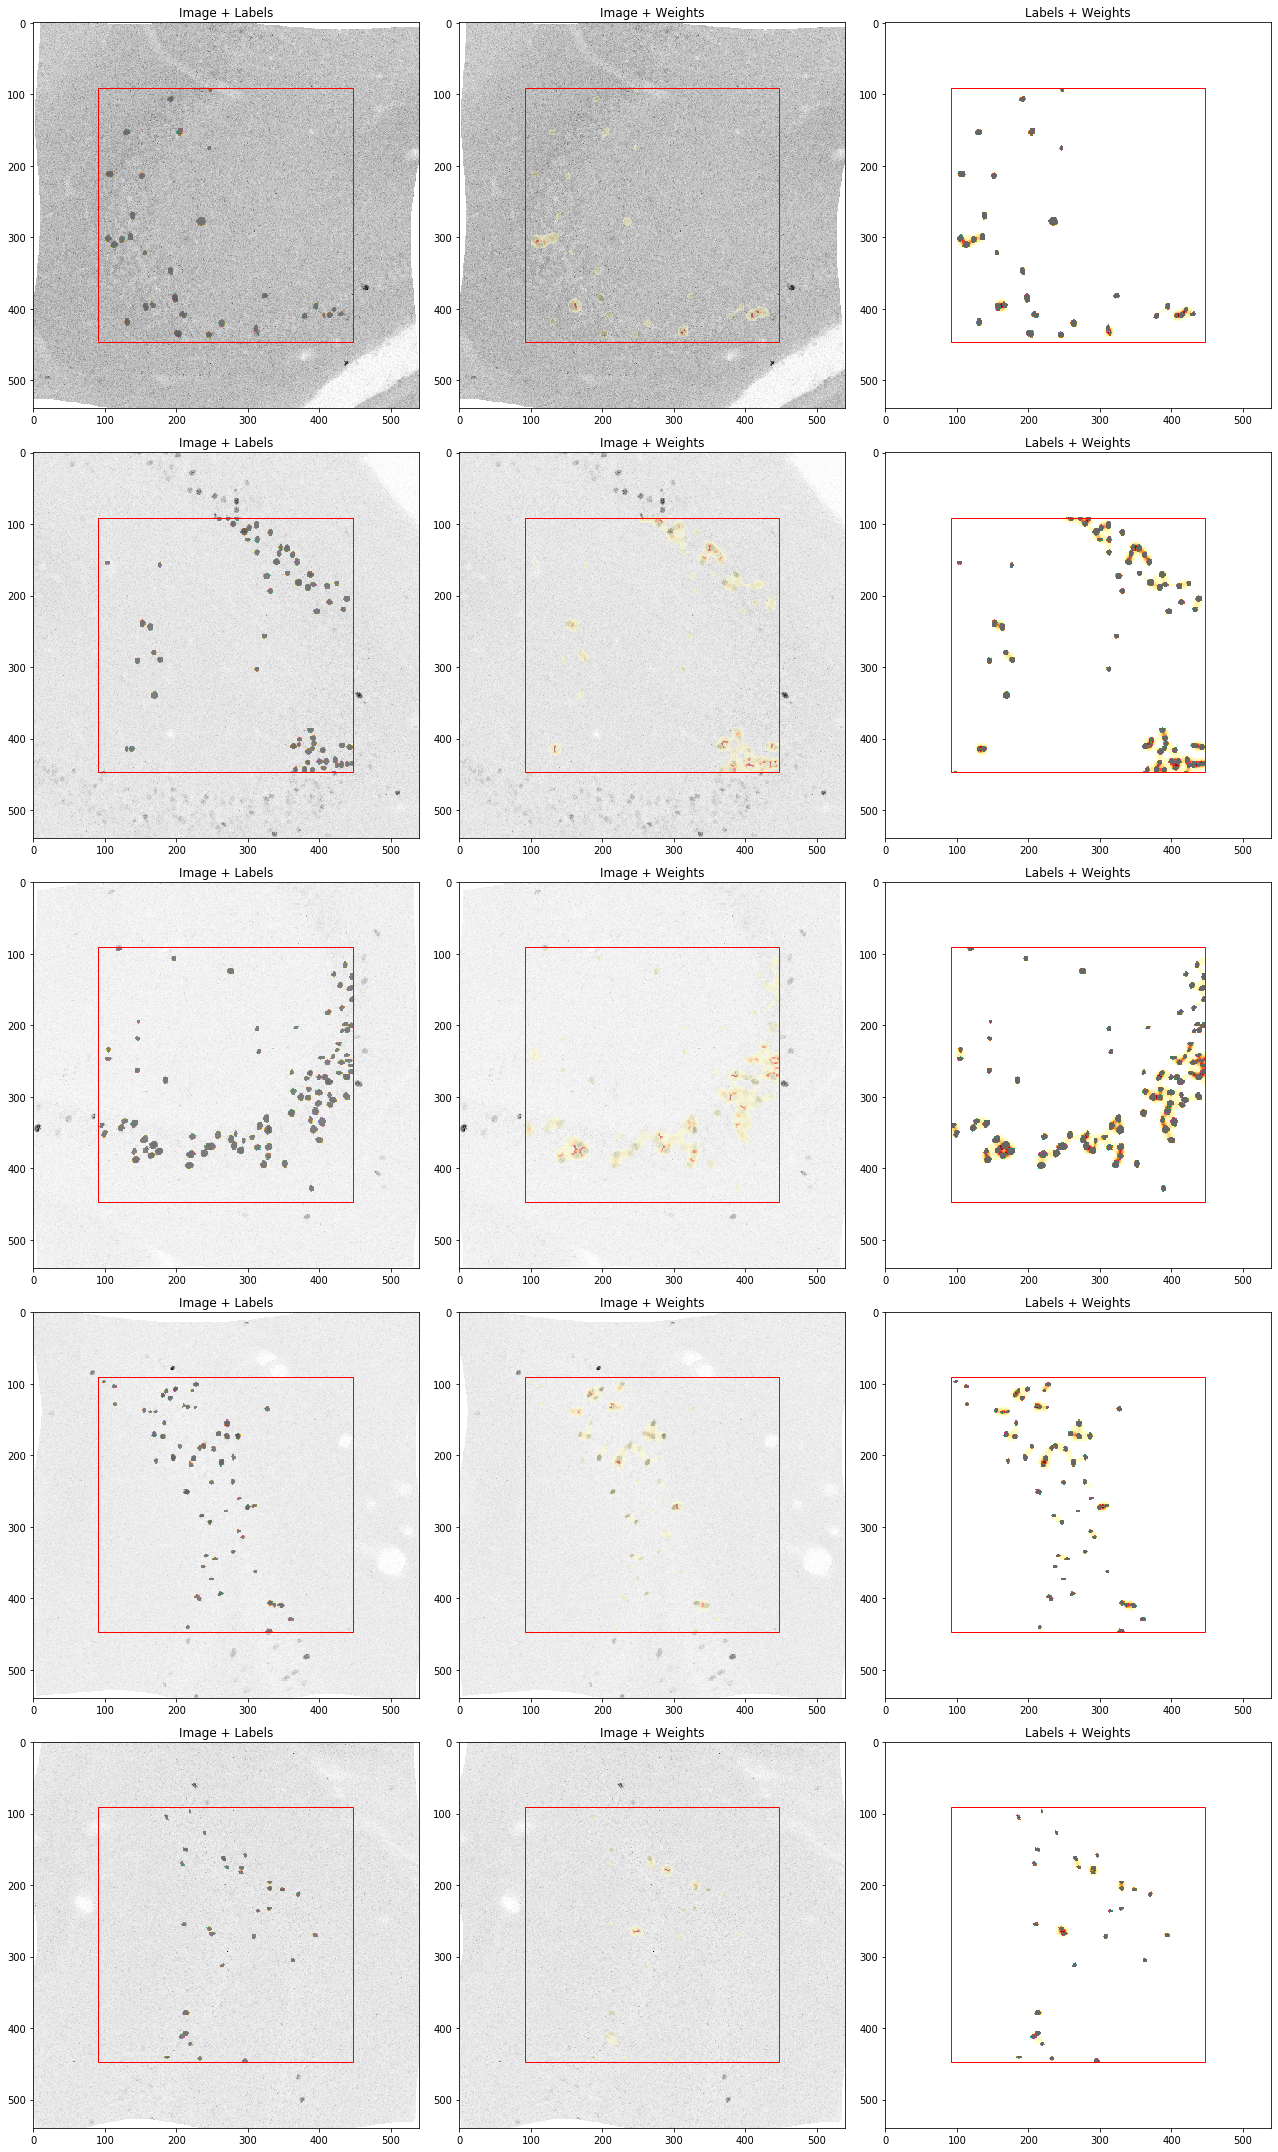

In [125]:
data.show_batch()

**Train**

Custom Loss Function

In [0]:
import pdb

class MyFlattenedLoss():
    "Same as `func`, but flattens input and target."
    def __init__(self, func, *args, 
                 axis:int=-1,
                 reduction_mode='sum', 
                 longify:bool=True, 
                 is_2d:bool=True, 
                 **kwargs):
        self.func,self.axis,self.longify,self.is_2d = func(*args,**kwargs),axis,longify,is_2d
        self.reduction_mode = reduction_mode

    def __repr__(self): return f"My FlattenedLoss of {self.func}"
    @property
    def reduction(self): return self.func.reduction
    @reduction.setter
    def reduction(self, v): self.func.reduction = v

    def __call__(self, 
                 input:Tensor, 
                 labels:Tensor, 
                 weights:Tensor,
                 red_func:Optional[Callable]=None, **kwargs)->Rank0Tensor:
        
        assert self.reduction_mode in ('sum','mean','none'), \
          'Check reduction_mode and chose between sum, mean and none'

        # flatten
        input = input.transpose(self.axis,-1).contiguous()
        labels = labels.transpose(self.axis,-1).contiguous()
        weights = weights.transpose(self.axis,-1).contiguous()

        # transform to long
        if self.longify: 
          labels = labels.long()          

        # reshape
        input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        labels = labels.view(-1)
        weights = weights.view(-1)

        res = nn.CrossEntropyLoss(reduction='none')(input, labels, **kwargs)

        if self.reduction_mode =='sum':
          return (weights * res).sum()
        elif self.reduction_mode =='mean':
          return (weights * res).mean()
        else:
          return weights * res

def CustomFlatLoss(*args, axis:int=-1, **kwargs):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    return MyFlattenedLoss(nn.CrossEntropyLoss, *args, axis=axis, **kwargs)

Learner Object

In [0]:
learn = Learner(data, 
                net,
                model_dir=DIR,
                opt_func=torch.optim.Adam,
                loss_func = CustomFlatLoss(axis=1, reduction_mode='sum'))
#opt_func=torch.optim.Adam, wd=1e-1, loss_func =

epoch,train_loss,valid_loss,time
0,129843.101562,#na#,00:11
1,126842.640625,#na#,00:11
2,129375.664062,#na#,00:11
3,130454.843750,#na#,00:10
4,131052.343750,#na#,00:10
5,131395.421875,#na#,00:10
6,130514.492188,#na#,00:11
7,120730.382812,#na#,00:09
8,121368.390625,#na#,00:11
9,113290.375000,#na#,00:10


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


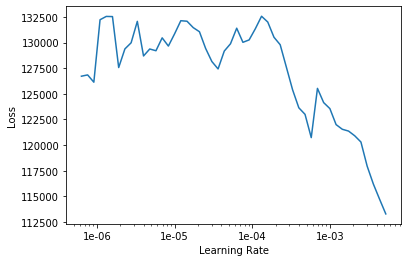

In [130]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(20,max_lr=1e-3)

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [0]:
#skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=1)